# Salsa/Bachata Classifier

We begin by importing necessary packages and loading the cleaned data set.

In [1]:
%load_ext autoreload
%autoreload 2

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# Helper functions
import functions

# To load data
import pickle

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Statistical modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [2]:
# Import dataframe
with open('data.pickle', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,track_name,album_name,artists,release_date,sections,genre
0,0.829,0.702,4,-9.681,0,0.0606,0.509,0.000003,0.0530,0.761,99.989,7J23B2HdvhvZvCM7hyv7ic,259240,4,El Regalito,No Volveré,[Oscar D'León],2019-11-20,"[{'start': 0.0, 'duration': 19.63042, 'confide...",salsa
1,0.614,0.433,0,-11.940,1,0.0741,0.498,0.000006,0.1650,0.674,118.049,3fS3Uc3P823QWJozrbt4Q0,248680,4,No Volveré,No Volveré,[Oscar D'León],2019-11-20,"[{'start': 0.0, 'duration': 8.28078, 'confiden...",salsa
2,0.827,0.711,8,-10.970,1,0.0501,0.356,0.000003,0.0535,0.965,97.559,4xIMgxIq1iaKdSNEToN2Bx,220027,4,Enamoraito,No Volveré,[Oscar D'León],2019-11-20,"[{'start': 0.0, 'duration': 26.93821, 'confide...",salsa
3,0.795,0.779,9,-10.642,0,0.1120,0.340,0.000010,0.1290,0.830,102.962,1w4ExH2EpK0nUpRtD2TfFC,253013,4,Llámame,No Volveré,[Oscar D'León],2019-11-20,"[{'start': 0.0, 'duration': 9.06153, 'confiden...",salsa
4,0.803,0.470,2,-10.782,1,0.0402,0.433,0.000000,0.0872,0.786,119.960,2pHYBVtJ9cTYkQPPZVFav7,237813,4,Corazón Gitano,No Volveré,[Oscar D'León],2019-11-20,"[{'start': 0.0, 'duration': 17.32051, 'confide...",salsa


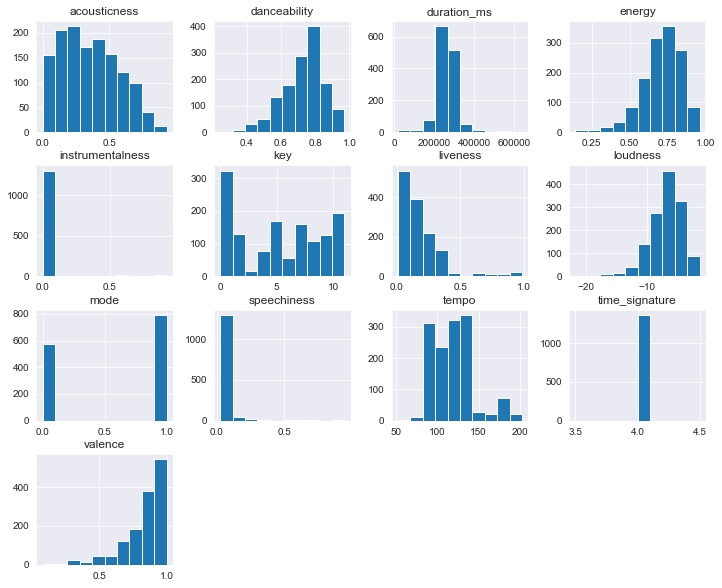

In [4]:
df.hist(figsize=(12,10));

## Feature Engineering

The two most accesible engineered features are of musical section analysis. We will feed into the model information about the number of musical sections each song has as well as the average length of these sections. Bachata follows a very typical verse/chorus/verse/chorus structured approach, whereas salsa has a more complex pattern. I expect these traits to make the songs more distinguishable to the model.

In [5]:
# Create two new columns from the `section` information
df['no_of_sectionss'] = df['sections'].map(lambda sections: len(sections))
df['avg_section_len'] = df['sections'].map(lambda sections: functions.avg_section_duration(sections))

# Create target column
df['is_salsa'] = df['genre'].map(lambda x: 1 if x == 'salsa' else 0)

# Split up df by genre to compare features
salsa_df, bachata_df = df[df['genre'] == 'salsa'], df[df['genre'] == 'bachata']

### Plotting engineered features

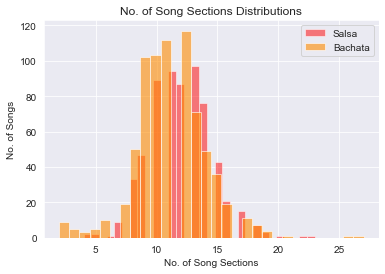

In [6]:
plt.hist(salsa_df['no_of_sectionss'],bins = 30, alpha=0.5, label='Salsa',color='red')
plt.hist(bachata_df['no_of_sectionss'],bins = 30, alpha=0.6, label='Bachata',color='darkorange')
plt.legend(loc='upper right')
plt.xlabel('No. of Song Sections')
plt.ylabel('No. of Songs')
plt.title('No. of Song Sections Distributions')
plt.show()

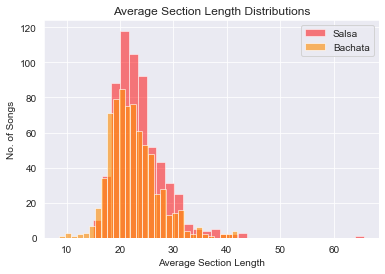

In [7]:
plt.hist(salsa_df['avg_section_len'],bins = 30, alpha=0.5, label='Salsa',color='red')
plt.hist(bachata_df['avg_section_len'],bins = 30, alpha=0.6, label='Bachata',color='darkorange')
plt.legend(loc='upper right')
plt.xlabel('Average Section Length')
plt.ylabel('No. of Songs')
plt.title('Average Section Length Distributions')
plt.show()

Unfortunately, neither of these features seem to be too distinguishable. We will have to see if the models can tell them apart and compare that to modeling the original data set.

## Statistical Modeling

In [8]:
# List of predictors that we want to include in the model
predictors = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
              'duration_ms', 'no_of_sectionss', 'avg_section_len']

# Same list as above but remove the two engineered features
predictors_no_engineered = list(filter(lambda x: x not in ['no_of_sectionss','avg_section_len'],predictors))

# Model target
target = ['is_salsa']

In [9]:
# Train-test split for data excluding engineered features
X = df.loc[:, predictors_no_engineered]
y = df.loc[:, target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# Train-test split for data including engineered features
X_eng = df.loc[:, predictors]
y_eng = df.loc[:, target]

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, y_eng, test_size = 0.3, random_state = 1)

### Modeling Engineered Features: Decision Tree and Random Forest

In [10]:
print('Decision tree grid search without engineered features: ', functions.decision_tree_gs(X_train, X_test, y_train, y_test))
print("")
print('Random forest grid search without engineered features: ', functions.random_forest_gs(X_train, X_test, y_train, y_test))

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 2}
Decision tree grid search without engineered features:  0.9170731707317074

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}
Random forest grid search without engineered features:  0.9390243902439024


In [11]:
print('Decision tree grid search with engineered features: ', functions.decision_tree_gs(X_train_eng, X_test_eng, y_train_eng, y_test_eng))
print("")
print('Random forest grid search with engineered features: ', functions.random_forest_gs(X_train_eng, X_test_eng, y_train_eng, y_test_eng))

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10}
Decision tree grid search with engineered features:  0.9121951219512195

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 30}
Random forest grid search with engineered features:  0.9195121951219513


The results of these grid searches show us that the the engineered features actually lower the accuracy of the model. This is interesting, as it suggests that the audio analysis data is inaccurate. I played a song and compared how Spotify classifies "sections" versus what a musician would perceive as a musical phrase, and I found several inconsitencies. Often times Spotify's algorithm fails to recognize a new musical phrase or will completely mischaracterize the start of a new phrase. This means that any inferences I attempted to engineer were not accurate and cannot actually be achieved by Spotify's current audio analysis data. I would need to generate that data myself, which I don't have time to do under the time constraints of this project.

Looking above, the distributions of these variables also clearly show a tremendous amount of overlap between these variables. It makes sense why the model could not distinguish well between them.

We will instantiate models for each of the above gridsearch-optimized models for a comparison.

In [10]:
# Create models based on above parameters other than the non-engineered random forest. These are just to have 
# for later comparison against other models

tree_no_eng = DecisionTreeClassifier(criterion='entropy',
                                max_depth=None,
                                min_samples_leaf=6,
                                min_samples_split=2,
                                random_state=1)

tree_eng = DecisionTreeClassifier(criterion='entropy',
                                max_depth=4,
                                min_samples_leaf=4,
                                min_samples_split=10,
                                random_state=1)

forest_no_eng = RandomForestClassifier(criterion='entropy',
                                max_depth=None,
                                min_samples_leaf=3,
                                min_samples_split=5,
                                n_estimators=30,
                                random_state=1)

forest_eng = RandomForestClassifier(criterion='entropy',
                                max_depth=None,
                                min_samples_leaf=3,
                                min_samples_split=10,
                                n_estimators=30,
                                random_state=1)

tree_no_eng.fit(X_train,y_train);
tree_eng.fit(X_train_eng, y_train_eng);
forest_no_eng.fit(X_train, y_train);
forest_eng.fit(X_train_eng, y_train_eng);

y_pred_tree_no_eng = tree_no_eng.predict(X_test)
y_pred_tree_eng = tree_eng.predict(X_test_eng)
y_pred_forest_no_eng = forest_no_eng.predict(X_test)
y_pred_forest_eng = forest_eng.predict(X_test_eng)

### Logistic Regression no engineered features

Since we see the engineered features do not help much, if at all, we will run this model without them entirely. We start by scaling the data and then fitting.

In [11]:
X_train_mm_scaled = MinMaxScaler().fit_transform(X_train)
 
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train_mm_scaled, y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
X_test_mm_scaled = MinMaxScaler().fit_transform(X_test)

y_hat_test = logreg.predict(X_test_mm_scaled)
y_hat_train = logreg.predict(X_train_mm_scaled)

In [13]:
# We subtract the two columns. If values or equal, difference will be zero. Then count number of zeros 
residuals_train = np.abs((y_train_eng.values).reshape(1,-1)[0] - y_hat_train)
train_counts = pd.Series(residuals_train).value_counts()
print(train_counts)
print(f"Log model predicts training data {round(train_counts[0]/(train_counts[0]+train_counts[1]),2)*100}% of the time")

0    814
1    140
dtype: int64
Log model predicts training data 85.0% of the time


In [14]:
residuals_test = np.abs((y_test_eng.values).reshape(1,-1)[0] - y_hat_test)
test_counts = pd.Series(residuals_test).value_counts()
print(test_counts)
print(f"Log model predicts training data {round(test_counts[0]/(test_counts[0]+test_counts[1]),2)*100} % of the time")

0    336
1     74
dtype: int64
Log model predicts training data 82.0 % of the time


In [15]:
# Save model predictions on test data for comparison
y_pred_log = logreg.predict(X_test_mm_scaled)

## Model Comparison

In [16]:
tree_no_eng_eval = functions.evaluate(y_test,y_pred_tree_no_eng,'Decision Tree No Engineered Features')
forest_no_eng_eval = functions.evaluate(y_test,y_pred_forest_no_eng,'Random Forest No Engineered Features')
tree_eng_eval = functions.evaluate(y_test,y_pred_tree_eng,'Decision Tree With Engineered Features')
forest_eng_eval = functions.evaluate(y_test,y_pred_forest_eng,'Random Forest With Engineered Features')
log_eval = functions.evaluate(y_test,y_pred_log,'Logistic Regression')

results_weighted= pd.DataFrame()
results_weighted= results_weighted.append([tree_no_eng_eval, forest_no_eng_eval, tree_eng_eval,
                                        forest_eng_eval,log_eval])

results_weighted.columns=["Model", "Accuracy Score", "Precision Score", "Recall Score", "F1 Score"]

results_weighted.set_index('Model')

,Accuracy Score,Precision Score,Recall Score,F1 Score
Model,,,,
Decision Tree No Engineered Features,0.917,0.938,0.878,0.907
Random Forest No Engineered Features,0.939,0.961,0.905,0.932
Decision Tree With Engineered Features,0.912,0.969,0.836,0.898
Random Forest With Engineered Features,0.920,0.959,0.862,0.908
Logistic Regression,0.820,0.789,0.831,0.809


In this scenario we care mainly about the F1 score. There is no greater penalty for incorrectly classifying one genre over the other - it is equally embarrassing to dance a bachata step over a salsa song as it is the other way around. Thus, we see the random forest with no engineered features is the superior model here.

## Moving on with Random Forest Model

The conditions for the best model (random forest w/ no engineered features): `{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}`

Let's generate a confusion matrix to begin to better understand the model and its limitations.

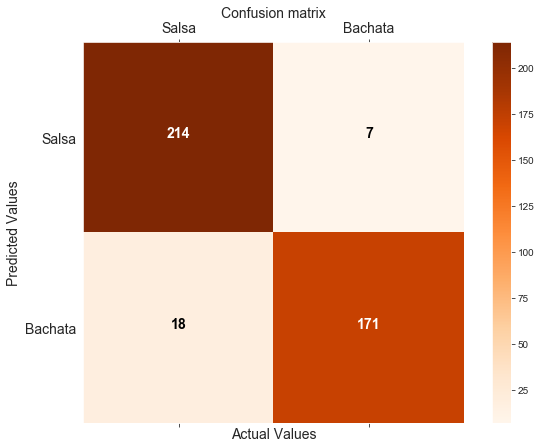

In [17]:
functions.plot_cm(y_test,y_pred_forest_no_eng)

We see that although the model performs well, it more often incorrectly classifies salsa songs as bachata rather than the other way around. Is this simply because there are more salsa songs in the test sample? We can take a closer look at feature importances to examine this.

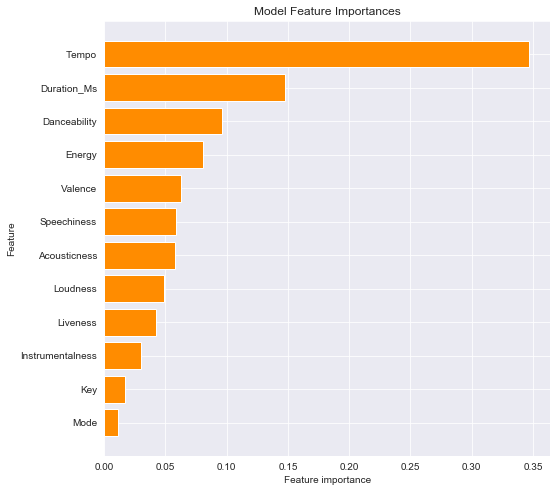

In [18]:
functions.plot_feature_importances(forest_no_eng,X_train)

I predict the incorrectly classified salsa songs will  exhibit traits of bachata songs in most features, and vice versa with bachata. I'll examine tempo and duration because they are the two most important features for the model and they also are two of the most interpretable features. 

In order to evaluate my prediction, I generate a DataFrame with all of the songs that were incorrectly classified by the model. I will then compare average values of the features in that set to average values of features in the train set.

In [19]:
# reshape test values
test_values = (y_test.values).reshape(1,-1)[0]

# find list indices of incorrect predictions
wrong_pred_indices = [i for i in range(len(test_values)) if test_values[i] != y_pred_forest_no_eng[i]]

# find dataframe indices of incorrect predictions 
df_indices = y_test.reset_index().iloc[wrong_pred_indices,:]['index'].values

# Select only the columns we want to inspect
columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
           'duration_ms', 'track_name', 'album_name', 'artists', 'genre']

# Create dataframe that includes ONLY songs that were incorrectly classified
incorrect_df = df.loc[df_indices,columns]

incorrect_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,track_name,album_name,artists,genre
94,0.603,0.427,5,-12.174,0,0.0305,0.654,0.000239,0.672,0.602,116.610,160888,Obsesión,El Diablo de la Salsa: Muchos Más,[Oscar D'León],salsa
1166,0.668,0.761,1,-6.618,0,0.0306,0.160,0.000000,0.159,0.725,102.040,258600,Close to You,Phase II,[Prince Royce],bachata
104,0.651,0.645,7,-11.023,1,0.0370,0.627,0.000769,0.318,0.900,147.470,281600,Sandunguera,Hits del Double Play,[Oscar D'León],salsa
655,0.726,0.705,9,-8.184,0,0.2740,0.518,0.000000,0.238,0.710,175.926,267787,Ella y Yo (feat. Don Omar),Todavía Me Amas: Lo Mejor de Aventura,[Aventura],bachata
526,0.765,0.719,10,-6.314,0,0.0488,0.296,0.000000,0.240,0.890,110.034,222267,Por Eso Estoy Contigo,Mi Ultima Grabacion,[Tito Nieves],salsa


In [20]:
# Creat df for train data
train_df = pd.concat([X_train,y_train],axis=1)

# Restore the genre column, which was stripped in the making of X_train. Need for comparisons below
train_df['genre'] = train_df.is_salsa.map(lambda x: 'salsa' if x == 1 else 'bachata')

#### Tempo Comparison

In [21]:
tempo_comp = pd.concat([
                        pd.DataFrame(train_df.groupby('genre').agg({'tempo':'mean'})),
                        pd.DataFrame(incorrect_df.groupby('genre').agg({'tempo':'mean'}))
                       ],
                        axis=1)

tempo_comp.columns = ['Tempo - Train Dataset',
                      'Tempo - Incorrect Predictions']

In [22]:
tempo_comp

,Tempo - Train Dataset,Tempo - Incorrect Predictions
genre,,
bachata,126.661263,130.296714
salsa,110.695911,130.785611


**for the below:** Figure out how to scale the text size and arrow dimensions. Maybe we can just take out the arrow and worry more about the text.

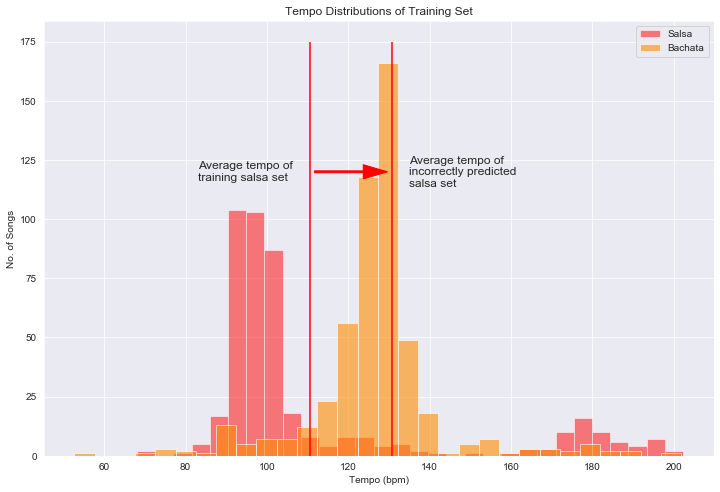

In [24]:
functions.plot_tempo_comp(train_df, tempo_comp)

The mean salsa tempo of the training set is closer to the  cluster of salsa tempos around 90 bpm, whereas the mean of incorrectly predicted salsa tracks is almost exactly equal to the mean bachata tempo from the training set. It is no wonder the model would think that a song with a tempo right in the bachata region would make an incorrect classification. 

Additionally, it appears that salsa has a lower average tempo than bachata. However, salsa is actually known to have a much higher tempo than bachata in real life. The discrepancy here must be attributed to Spotify API's tempo analysis. I have found after listening to several songs in the 90-100 salsa bpm range that many songs with a tempo above 160 have been incorrectly quantified at half tempo by Spotify API's analysis. In reality, we should see many more data points accompanying the small cluster of points that are roughly centered around 178 bpm. I am curious about songs in the range of about 115 - 140 bpm though. My first instinct to fix this problem would just be to double the tempo of every salsa song that has a tempo below 160 bpm, which looks like a good cutoff. However, by doing this we would have to consider the ramifications of the following:

1. Not every song in the salsa data set is actually salsa. Songs are assigned genres at the album level. Often times salsa artists include one or even more "cha cha cha" songs in their albums to add variety. The main distinction between cha cha cha songs and salsa is the tempo. 
    - With some research, we could find a range of tempos for cha cha cha songs and remove data points within that range from our data set.
    - Run the models again


2. It turns out salsa artists also like to dabble in other genres and from time to time will even include a reggaeton song or merengue (or even bachata!). It is unfortunate the genres are assigned at the album level because there is really no way other than looking through individual tracks in an album to identify non-salsa and non-bachata songs.

#### Duration Comparison

Let's continue and evaluate the comparison in track duration.

In [25]:
duration_comp = pd.concat([pd.DataFrame(train_df.groupby('genre').agg({'duration_ms':'mean'})),pd.DataFrame(incorrect_df.groupby('genre').agg({'duration_ms':'mean'}))],axis=1)
duration_comp.columns = ['Duration - Train Dataset','Duration - Incorrect Predictions']
duration_comp

,Duration - Train Dataset,Duration - Incorrect Predictions
genre,,
bachata,245257.758755,296536.142857
salsa,276504.211364,233145.833333


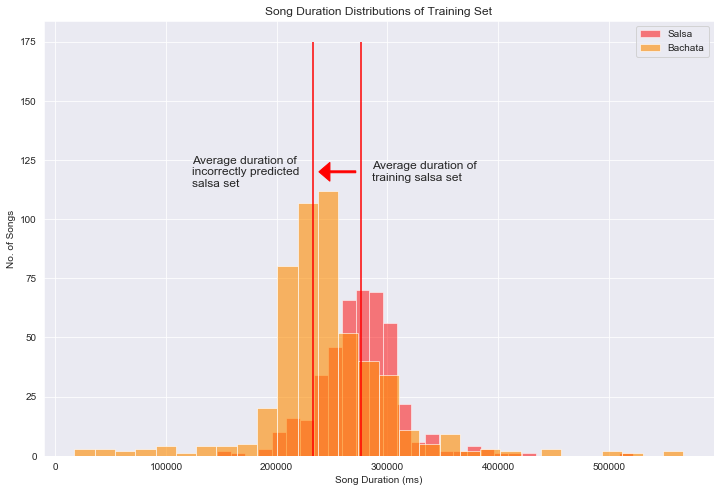

In [26]:
functions.plot_duration_comp(train_df,duration_comp)

Again, we see the incorrectly predicted salsa songs have an average tempo that more closely resembles that of a bachata song. There is probably nothing that really can be done here, because these values are not extrapolated by any Spotify API metrics. They are simply an inherent property of the song. 

# Conclusion

In general, I believe most features of the model could be improved by Spotify improving its audio analysis algorithms. Is this really necessary though if we already have such a robust model? For our purposes, maybe not. However, if I were to expand this to a multi class problem it would be imperative for all of the audio features to be correct.